In [1]:
import enum
from dataclasses import dataclass
from typing import Any

import numpy as np

from matplotlib import pyplot as plt

In [2]:
def label_axes(ax: plt.Axes, scale: float) -> None:
    ax.set_xlabel("$E$ / $\\text{GeV}$")
    ax.set_ylabel(
        f"$ E^{{{scale}}} \\frac{{dN}}{{dE}} $ / $ \\text{{GeV}}^{{{scale - 1:.2g}}}$"
    )

In [3]:
DEBUG = False

# Galactic CR model

Broken power laws with per-primary normalization and


In [4]:
R0 = 1e3  # GV, constant for scaling

In [5]:
from num2tex import num2tex

PARTICLE_CMAP = plt.colormaps["turbo"]


class Particle(enum.IntEnum):
    H = 1
    He = 2
    C = 6
    O = 8
    Mg = 12
    Si = 14
    Fe = 26

    @property
    def Z(self) -> int:
        return self.value

    @property
    def color(self) -> Any:
        all_particles = list(Particle)
        idx = all_particles.index(self)
        return PARTICLE_CMAP(idx / (len(all_particles) - 1))


PRIMARY_PARTICLES = [Particle.H, Particle.He]


@dataclass
class PowerLawComponent:
    I: float  # intensity, TODO units
    alpha: float  # pre-knee power law index

    def pack(self) -> np.ndarray:
        return np.array([self.I, self.alpha])

    def labels(self) -> np.ndarray:
        return ["I", "alpha"]

    @classmethod
    def unpack(cls, v: np.ndarray) -> "PowerLawComponent":
        return PowerLawComponent(I=v[0], alpha=v[1])


@dataclass
class GalacticCRModel:
    components: dict[Particle, PowerLawComponent]
    R_break: float  # break rigidity, GV
    d_alpha: float  # PL index change at the knee, same for every primary
    knee_softness: float  # knee softness parameter

    def __str__(self) -> str:
        component_strs = [
            f"$ \\text{{{p.name}}} \\propto R ^{{-{pl.alpha:.2f}}} $"
            for p, pl in self.components.items()
        ]
        component_strs.append(
            f"$ R_b = {num2tex(self.R_break, precision=3, exp_format='cdot')}~\\text{{GV}} $"
        )
        component_strs.append(f"$ \\Delta \\alpha = {self.d_alpha:.2f} $")
        component_strs.append(f"$ s = {self.knee_softness:.2f} $")
        return ", ".join(component_strs)

    def compute(self, E: np.ndarray, particle: Particle) -> np.ndarray:
        if DEBUG:
            print(E, particle)
        pl = self.components.get(particle)
        if DEBUG:
            print(pl)
        if pl is None:
            raise ValueError(
                f"Unsupported particle: {particle}. Supported values are {list(self.components.keys())}."
            )
        R = E / float(particle.Z)
        y = pl.I * (R / R0) ** -pl.alpha
        y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (
            self.d_alpha / self.knee_softness
        )
        # TODO: integrate over energy bins instead of taking the center value?
        return y

    def plot(
        self,
        Emin: float,
        Emax: float,
        scale: float,
        axes: plt.Axes | None = None,
    ) -> plt.Axes:
        if axes is not None:
            ax = axes
        else:
            _, ax = plt.subplots()
        E_grid = np.logspace(np.log10(Emin), np.log10(Emax), 300)
        E_factor = E_grid**scale
        for p in self.components.keys():
            ax.loglog(
                E_grid, E_factor * self.compute(E_grid, p), label=p.name, color=p.color
            )
        ax.legend()
        label_axes(ax, scale)
        return ax

    def pack(self) -> np.ndarray:
        subvectors = [self.components[p].pack() for p in PRIMARY_PARTICLES]
        subvectors.append(np.array([self.R_break, self.d_alpha, self.knee_softness]))
        return np.hstack(subvectors)

    def labels(self) -> list[str]:
        labels: list[str] = []
        for p in PRIMARY_PARTICLES:
            for param_label in self.components[p].labels():
                labels.append(f"{p.name}_{param_label}")
        labels.extend(["R_break", "d_alpha", "s_knee"])
        return labels

    @classmethod
    def unpack(
        cls, v: np.ndarray, start_idx: int = 0, particles: list[Particle] | None = None
    ) -> tuple["GalacticCRModel", int]:
        idx = start_idx
        components: dict[Particle, PowerLawComponent] = dict()
        for particle in particles or PRIMARY_PARTICLES:
            components[particle] = PowerLawComponent.unpack(v[idx : idx + 3])
            idx += 2
        model = GalacticCRModel(
            components=components,
            R_break=v[idx],
            d_alpha=v[idx + 1],
            knee_softness=v[idx + 2],
        )
        return model, idx + 3


example_cr_model = GalacticCRModel(
    components={p: PowerLawComponent(I=1.0, alpha=2.4) for p in PRIMARY_PARTICLES},
    R_break=5e5,
    d_alpha=1,
    knee_softness=10,
)
model_packed = example_cr_model.pack()
print(f"Model param vector ({len(model_packed)} elements): {model_packed}")
recovered_model, idx = GalacticCRModel.unpack(example_cr_model.pack())
assert idx == len(model_packed)
assert recovered_model == example_cr_model

Model param vector (7 elements): [1.0e+00 2.4e+00 1.0e+00 2.4e+00 5.0e+05 1.0e+00 1.0e+01]


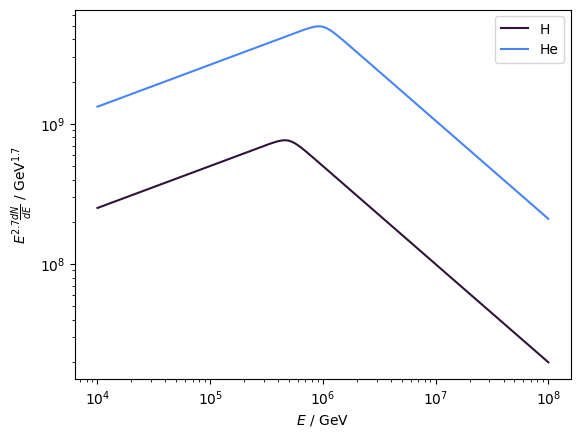

In [6]:
example_cr_model.plot(1e4, 1e8, scale=2.7);

# Experimental data and energy scale shifts


In [7]:
R_MIN = 7e2  # GV
R_MAX = 1e5  # GV

In [8]:
from model.utils import load_data


class GalacticCRExperiment(enum.Enum):
    AMS02 = "AMS-02"
    CALET = "CALET"
    DAMPE = "DAMPE"
    CREAM = "CREAM"

    def available_particles(self) -> list[Particle]:
        match self:
            case GalacticCRExperiment.AMS02:
                return list(Particle)
            case GalacticCRExperiment.CALET:
                return [
                    Particle.H,
                    # Particle.He,
                    Particle.C,
                    Particle.O,
                    Particle.Fe,
                ]
            case GalacticCRExperiment.DAMPE:
                return [Particle.H, Particle.He]
            case GalacticCRExperiment.CREAM:
                return list(Particle)

    def marker(self) -> str:
        match self:
            case GalacticCRExperiment.AMS02:
                return "o"
            case GalacticCRExperiment.CALET:
                return "s"
            case GalacticCRExperiment.DAMPE:
                return "v"
            case GalacticCRExperiment.CREAM:
                return "*"


@dataclass
class GalacticCRData:
    E: np.ndarray
    dNdE: np.ndarray
    dNdE_errlo: np.ndarray
    dNdE_errhi: np.ndarray

    experiment: GalacticCRExperiment
    particle: Particle

    energy_scale_shift: float = 1.0

    def with_shifted_energy_scale(self, f: float) -> "GalacticCRData":
        return GalacticCRData(
            E=self.E * f,
            dNdE=self.dNdE / f,
            dNdE_errlo=self.dNdE_errlo / f,
            dNdE_errhi=self.dNdE_errhi / f,
            experiment=self.experiment,
            particle=self.particle,
            energy_scale_shift=self.energy_scale_shift * f,
        )

    @classmethod
    def load(cls, exp: GalacticCRExperiment, p: Particle) -> "GalacticCRData":
        data = load_data(
            filename=f"{exp.value}_{p.name}_energy.txt",
            slope=0,  # multiplying data by E^0 = leaving as-is
            norm=1,  # not renormalizing
            min_energy=R_MIN * p.Z,
            max_energy=R_MAX * p.Z,
        )
        return GalacticCRData(
            E=data[0],
            dNdE=data[1],
            dNdE_errlo=data[2],
            dNdE_errhi=data[3],
            experiment=exp,
            particle=p,
        )

    def plot(
        self,
        scale: float,
        ax: plt.Axes | None = None,
        color: Any | None = None,
    ) -> plt.Axes:
        """Note: apply log scaling externally"""
        if ax is None:
            _, ax = plt.subplots()
        E_factor = self.E**scale
        label = f"{self.experiment.value} {self.particle.name}"
        if not np.isclose(self.energy_scale_shift, 1.0):
            label += f" $(E \\times {self.energy_scale_shift:.3g})$"
        ax.errorbar(
            self.E,
            E_factor * self.dNdE,
            yerr=[E_factor * self.dNdE_errlo, E_factor * self.dNdE_errhi],
            color=color or self.particle.color,
            label=label,
            markersize=6.0,
            elinewidth=1.8,
            capthick=1.8,
            fmt=self.experiment.marker(),
        )
        label_axes(ax, scale)
        ax.legend()
        return ax

In [9]:
EXPERIMENTS = [GalacticCRExperiment.AMS02, GalacticCRExperiment.DAMPE]

In [10]:
FitData = dict[GalacticCRExperiment, dict[Particle, GalacticCRData]]
FIT_DATA: FitData = {
    exp: {p: GalacticCRData.load(exp, p) for p in PRIMARY_PARTICLES}
    for exp in EXPERIMENTS
}

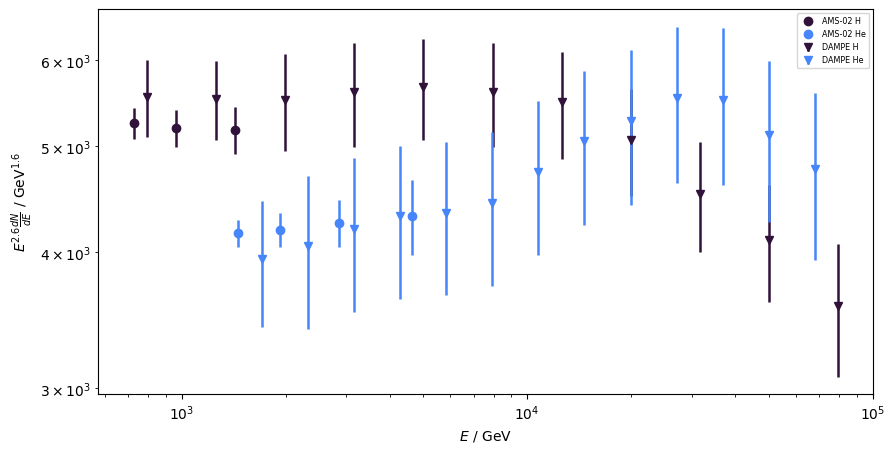

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in FIT_DATA.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

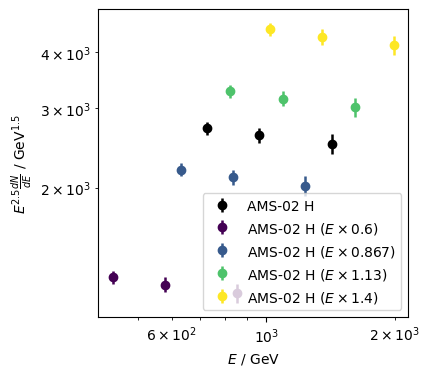

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
scale = 2.5

cmap = plt.colormaps["viridis"]
fit_data = FIT_DATA[EXPERIMENTS[0]][PRIMARY_PARTICLES[0]]
fit_data.plot(scale, ax=ax, color="black")
for shift in np.linspace(0.6, 1.4, 4):
    fit_data.with_shifted_energy_scale(f=shift).plot(
        scale, ax=ax, color=cmap((shift - 0.7) / (1.3 - 0.7))
    )
ax.set_xscale("log")
ax.set_yscale("log")

In [13]:
@dataclass
class ExperimentEnergyScaleShiftsModel:
    shifts: dict[GalacticCRExperiment, float]

    def pack(self) -> np.ndarray:
        return np.array([self.shifts[exp] for exp in EXPERIMENTS])

    def labels(self) -> list[str]:
        return [f"f_{exp.name}" for exp in EXPERIMENTS]

    @classmethod
    def unpack(
        cls,
        v: np.ndarray,
        start_idx: int = 0,
        experiments: list[GalacticCRExperiment] | None = None,
    ) -> tuple["ExperimentEnergyScaleShiftsModel", int]:
        experiments_coll = experiments or EXPERIMENTS
        shifts = {exp: shift for exp, shift in zip(experiments_coll, v[start_idx:])}
        return ExperimentEnergyScaleShiftsModel(shifts), start_idx + len(
            experiments_coll
        )


example_shifts = ExperimentEnergyScaleShiftsModel({e: 1.0 for e in EXPERIMENTS})
assert (
    example_shifts == ExperimentEnergyScaleShiftsModel.unpack(example_shifts.pack())[0]
)

# Below-knee composition fit


In [14]:
@dataclass
class Model:
    cr: GalacticCRModel
    energy_shifts: ExperimentEnergyScaleShiftsModel

    def pack(self) -> np.ndarray:
        return np.hstack((self.cr.pack(), self.energy_shifts.pack()))

    def labels(self) -> list[str]:
        return self.cr.labels() + self.energy_shifts.labels()

    @classmethod
    def unpack(self, v: np.ndarray) -> "Model":
        cr, end_idx = GalacticCRModel.unpack(v)
        energy_shifts, end_idx = ExperimentEnergyScaleShiftsModel.unpack(v, end_idx)
        assert end_idx == v.size
        return Model(cr=cr, energy_shifts=energy_shifts)

    def plot(self, fit_data: FitData, scale: float) -> None:
        fig, ax = plt.subplots()

        for exp, data_by_particle in fit_data.items():
            for _, data in data_by_particle.items():
                shift = self.energy_shifts.shifts.get(exp, 1.0)
                data.with_shifted_energy_scale(shift).plot(scale=scale, ax=ax)

        primaries = list(self.cr.components.keys())
        self.cr.plot(
            Emin=R_MIN * min(p.Z for p in primaries),
            Emax=R_MAX * max(p.Z for p in primaries),
            scale=scale,
            axes=ax,
        )

        ax.legend(fontsize="xx-small")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(str(self.cr))
        return fig

    def description(self) -> str:
        lines = [
            f"{label} = {value:.2e}" for label, value in zip(self.labels(), self.pack())
        ]
        return "\n".join(lines)


example_mod = Model(cr=example_cr_model, energy_shifts=example_shifts)
packed = example_mod.pack()
print(f"Model parameter vector: {len(packed)} elements")
assert example_mod == Model.unpack(packed)

Model parameter vector: 9 elements


In [35]:
from scipy import stats


DEBUG_PRIOR = False


def debug_log(message: str) -> None:
    if DEBUG_PRIOR:
        print(message)


def logprior(m: Model) -> float:
    for component in m.cr.components.values():
        if component.I < 0:
            debug_log(f"{component}: negative I => prior = 0")
            return -np.inf
        if component.alpha < 0:
            debug_log(f"{component}: negative alpha => prior = 0")
            return -np.inf

    if m.cr.knee_softness < 0:
        debug_log(f"negative knee softness: {m.cr.knee_softness} => prior = 0")
        return -np.inf

    if not R_MIN < m.cr.R_break < 1e8:
        debug_log(f"out of bounds R_break = {m.cr.R_break} => prior = 0")
        return -np.inf

    # TODO: define other informative priors on Galactic CR model

    res = 0
    for experiment, shift in m.energy_shifts.shifts.items():
        if shift < 0:
            debug_log(f"negative shift for {experiment} => prior = 0")
            return -np.inf
        # TODO: look up realistic priors from experiments' systematic uncertainties on energy scale
        sigma = 0.1  # in decades
        res += stats.norm.logpdf(np.log10(shift), loc=0, scale=sigma)
    return res


def loglikelihood(m: Model) -> float:
    loglike = 0
    for experiment, particle_data in FIT_DATA.items():
        for particle, data in particle_data.items():
            data = data.with_shifted_energy_scale(f=m.energy_shifts.shifts[experiment])
            prediction = m.cr.compute(E=data.E, particle=particle)
            loglike_per_bin = -(
                np.where(
                    prediction > data.dNdE,
                    ((prediction - data.dNdE) / data.dNdE_errhi) ** 2,
                    ((prediction - data.dNdE) / data.dNdE_errlo) ** 2,
                )
            )
            if np.any(np.isnan(loglike_per_bin)):
                # print(data, prediction)
                return -np.inf
            loglike += np.sum(loglike_per_bin)
    return loglike


def generate_initial_model() -> Model:
    return Model(
        cr=GalacticCRModel(
            components={
                p: PowerLawComponent(
                    I=(10 ** stats.norm.rvs(loc=-4, scale=0.5)) / (p.Z**2.7),
                    alpha=stats.norm.rvs(loc=2.7, scale=0.1),
                )
                for p in PRIMARY_PARTICLES
            },
            R_break=(
                10 ** stats.norm.rvs(loc=6.4, scale=0.5)
                / np.random.randint(low=1, high=26)
            ),
            d_alpha=stats.norm.rvs(loc=0, scale=1) ** 2,
            knee_softness=10 ** stats.norm.rvs(loc=0.3, scale=0.5),
        ),
        energy_shifts=ExperimentEnergyScaleShiftsModel(
            shifts={exp: 10 ** stats.norm.rvs(loc=0, scale=0.05) for exp in EXPERIMENTS}
        ),
    )

In [36]:
def logpost(v: np.ndarray) -> float:
    model = Model.unpack(v)
    logpi = logprior(model)
    if not np.isfinite(logpi):
        return logpi
    return logpi + loglikelihood(model)

In [89]:
print(generate_initial_model().description())

H_I = 1.60e-04
H_alpha = 2.63e+00
He_I = 6.88e-06
He_alpha = 2.75e+00
R_break = 2.79e+05
d_alpha = 7.45e-02
s_knee = 4.67e+00
f_AMS02 = 9.92e-01
f_DAMPE = 1.21e+00


## Pre-optimization


[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (0.7, 1.3), (0.7, 1.3)]


/tmp/ipykernel_57798/23624993.py:76: RuntimeWarning: overflow encountered in power
  y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.0957136182470917
             x: [ 1.268e-04  2.585e+00  1.635e-05  2.517e+00  2.192e+04
                  2.898e-01  3.794e+02  1.300e+00  1.300e+00]
           nit: 4282
          nfev: 6082
 final_simplex: (array([[ 1.268e-04,  2.585e+00, ...,  1.300e+00,
                         1.300e+00],
                       [ 1.268e-04,  2.585e+00, ...,  1.300e+00,
                         1.300e+00],
                       ...,
                       [ 1.268e-04,  2.585e+00, ...,  1.300e+00,
                         1.300e+00],
                       [ 1.268e-04,  2.585e+00, ...,  1.300e+00,
                         1.300e+00]]), array([ 2.096e+00,  2.096e+00,  2.096e+00,  2.096e+00,
                        2.096e+00,  2.096e+00,  2.096e+00,  2.096e+00,
                        2.096e+00,  2.096e+00]))


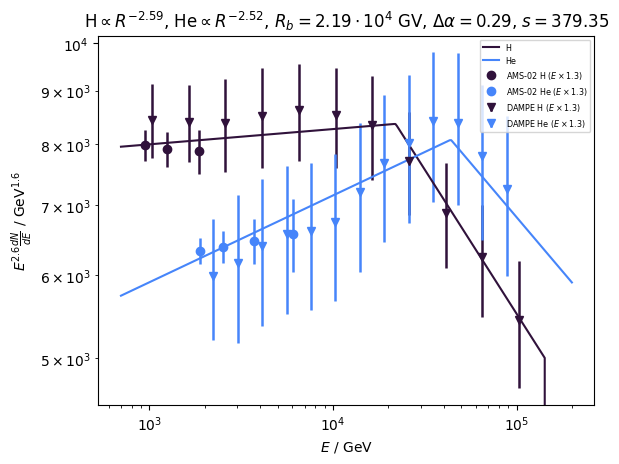

In [25]:
from scipy import optimize

bounds = [(None, None)] * len(generate_initial_model().pack())
# FIXME: unstable dependency on the model packing, assumes energy shifts are packed last
for i in range(len(EXPERIMENTS)):
    bounds[len(bounds) - i - 1] = (0.7, 1.3)
print(bounds)


def minimized_fn(v: np.ndarray) -> float:
    return -logpost(v)


res = optimize.minimize(
    minimized_fn,
    x0=generate_initial_model().pack(),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
    bounds=bounds,
)
print(res)

_ = Model.unpack(res.x).plot(FIT_DATA, scale=2.6)

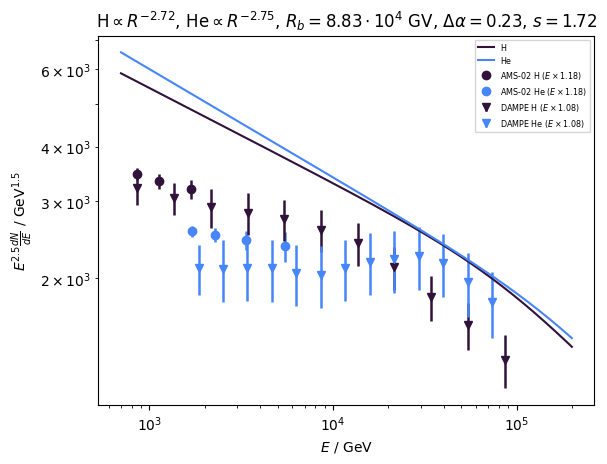

In [19]:
_ = generate_initial_model().plot(fit_data=FIT_DATA, scale=2.5)

In [20]:
import emcee

n_steps = 10_000
n_walkers = 128

n_dim = generate_initial_model().pack().size


sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=logpost,
)
initial_state = np.array([generate_initial_model().pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())
print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)
print(f"MCMC sample ready, shape: {theta_sample.shape}")

  1%|▏         | 136/10000 [00:02<02:20, 70.21it/s]/tmp/ipykernel_57798/23624993.py:76: RuntimeWarning: overflow encountered in power
  y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (
  2%|▏         | 240/10000 [00:03<02:12, 73.74it/s]/tmp/ipykernel_57798/987826104.py:51: RuntimeWarning: overflow encountered in square
  ((prediction - data.dNdE) / data.dNdE_errhi) ** 2,
/tmp/ipykernel_57798/987826104.py:52: RuntimeWarning: overflow encountered in square
  ((prediction - data.dNdE) / data.dNdE_errlo) ** 2,
/tmp/ipykernel_57798/987826104.py:51: RuntimeWarning: overflow encountered in divide
  ((prediction - data.dNdE) / data.dNdE_errhi) ** 2,
/tmp/ipykernel_57798/987826104.py:52: RuntimeWarning: overflow encountered in divide
  ((prediction - data.dNdE) / data.dNdE_errlo) ** 2,
  3%|▎         | 304/10000 [00:04<02:06, 76.42it/s]/tmp/ipykernel_57798/23624993.py:76: RuntimeWarning: divide by zero encountered in divide
  y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (


Acceptance fraction: 0.29037500000000005


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [381.74439615 194.22240826 387.4430135  217.09558682 256.82445552
 106.91867323 256.76138624 408.36576612 403.28310811]


tau = array([381.74439615, 194.22240826, 387.4430135 , 217.09558682,
       256.82445552, 106.91867323, 256.76138624, 408.36576612,
       403.28310811])
burn_in = 2040 thin = 816
MCMC sample ready, shape: (1152, 9)


In [29]:
theta_sample.shape

(1152, 9)

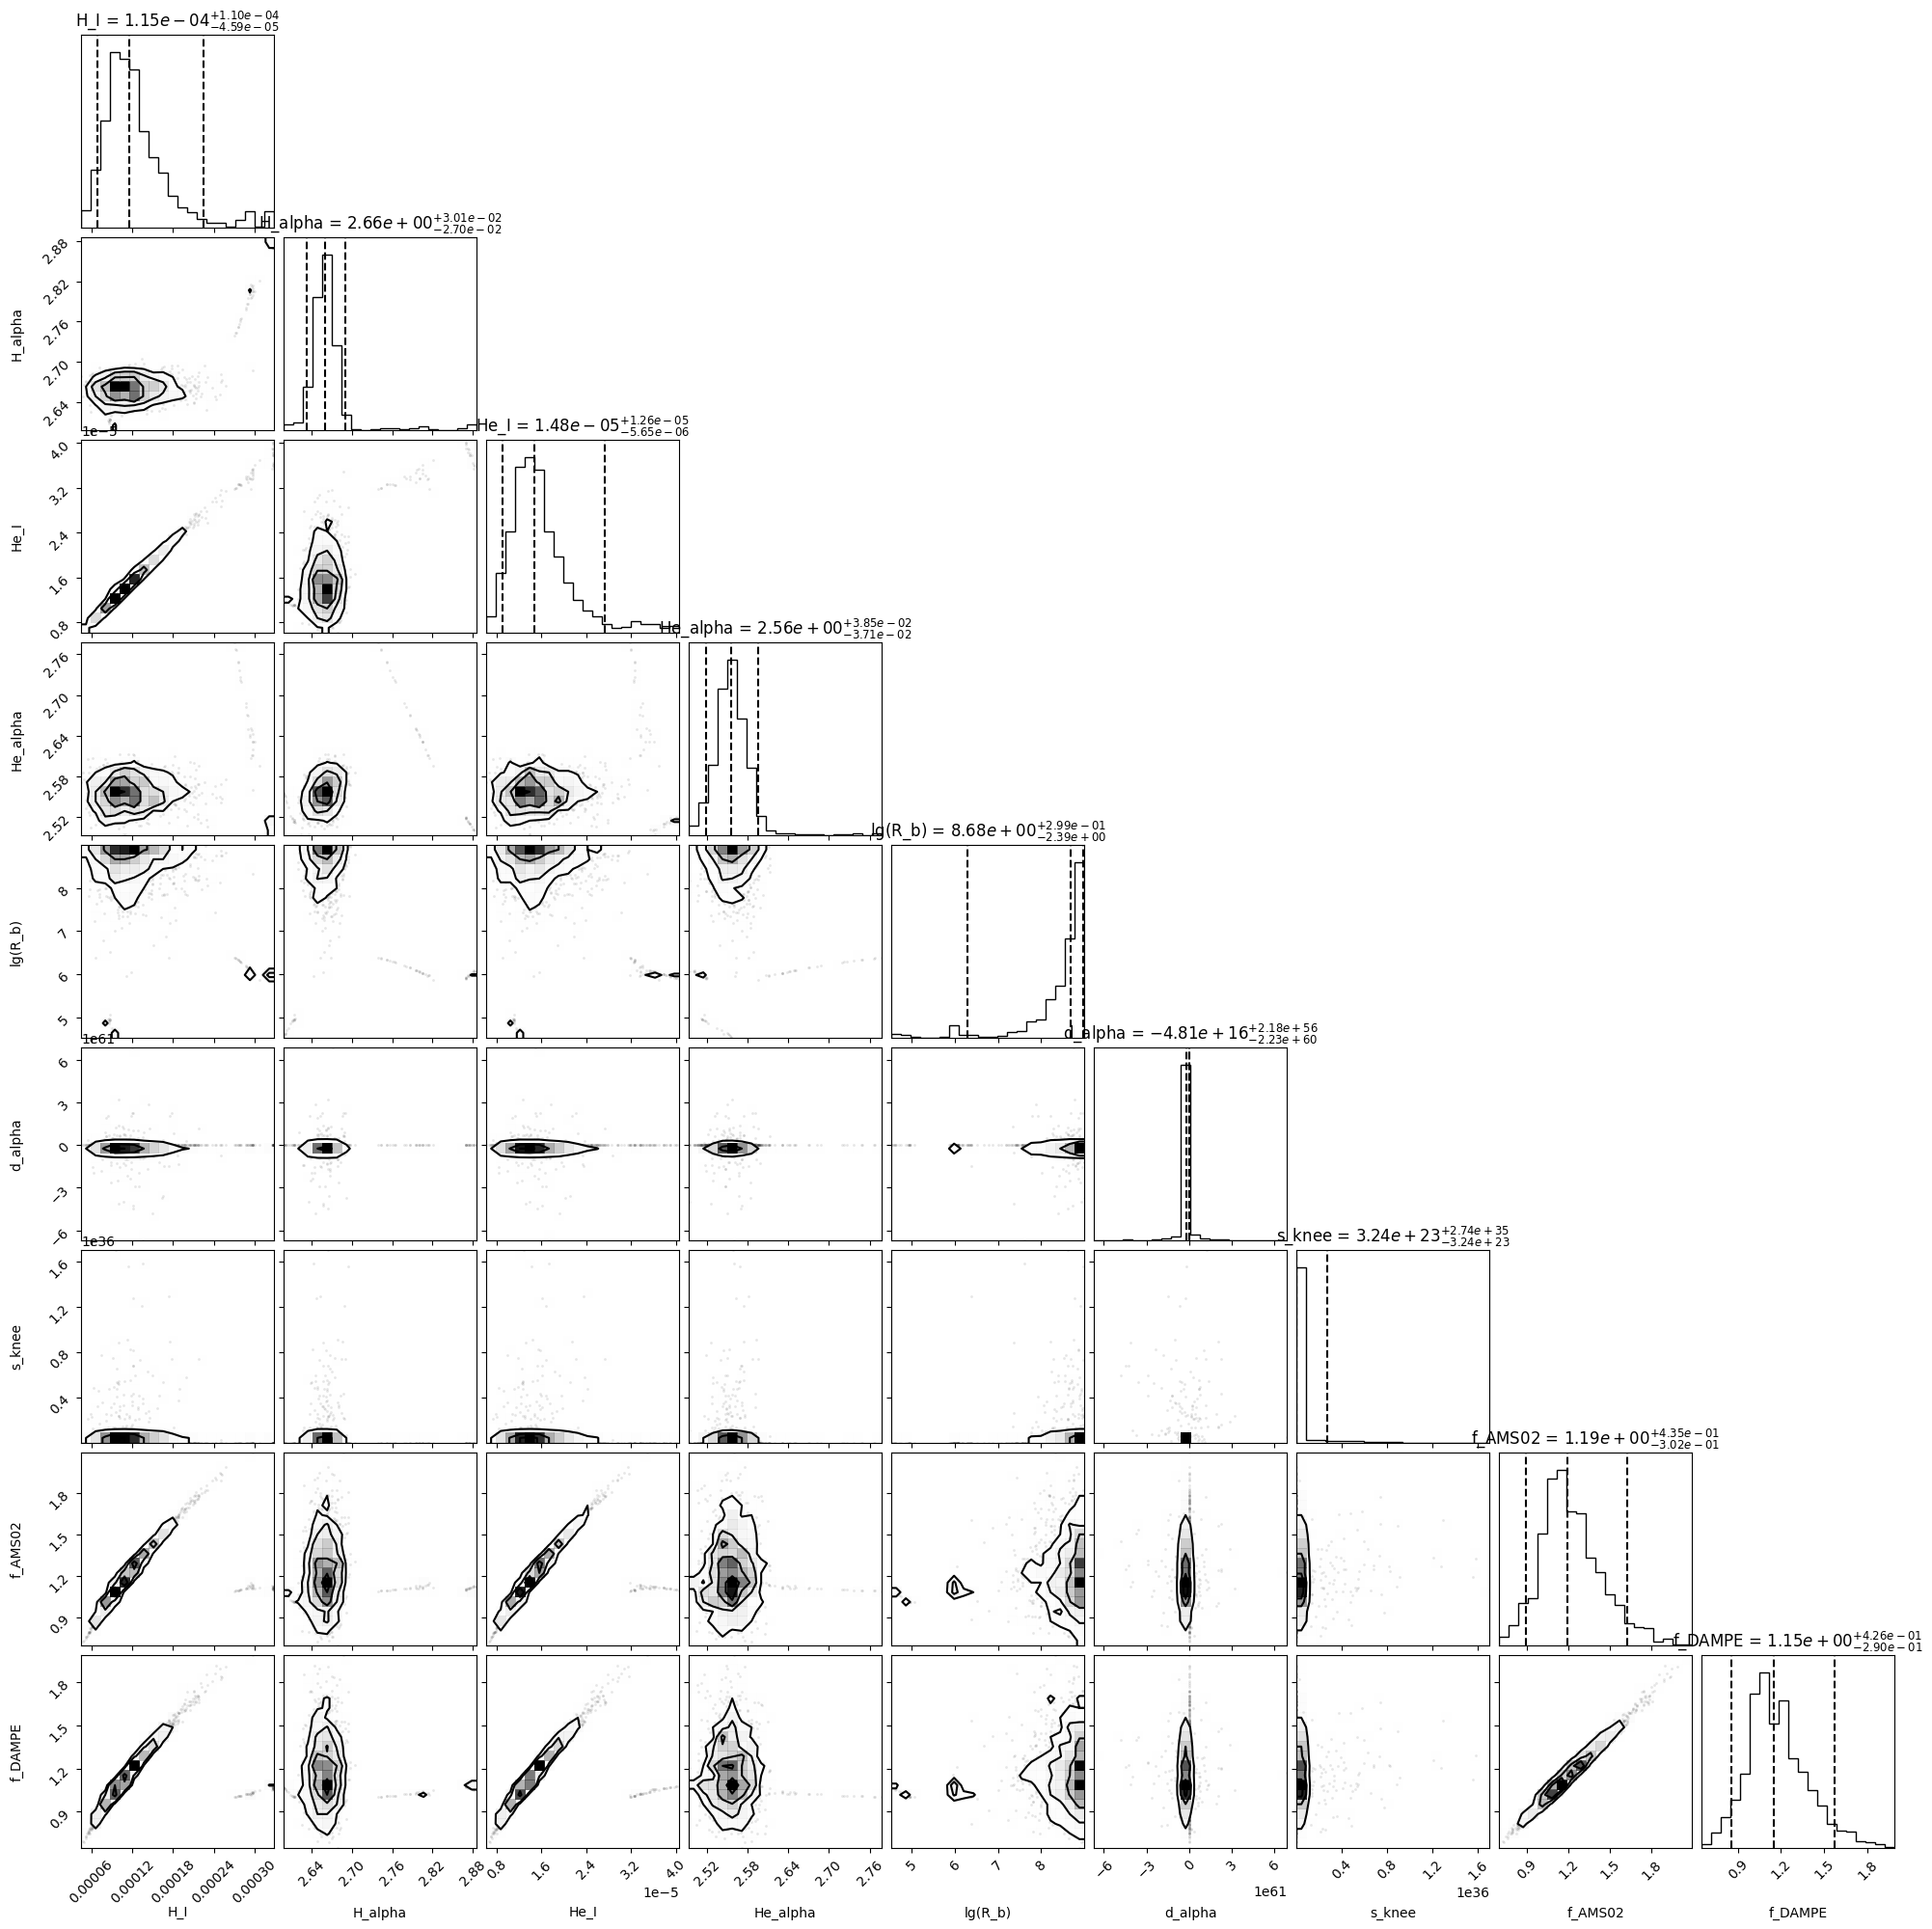

In [34]:
import corner

sample_to_plot = theta_sample
sample_labels = generate_initial_model().labels()

R_break_dim = generate_initial_model().labels().index("R_break")
sample_to_plot[:, R_break_dim] = np.log10(sample_to_plot[:, R_break_dim])
sample_labels[R_break_dim] = "lg(R_b)"

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    title_fmt=".2e",
    quantiles=[0.05, 0.5, 0.95],
)